# Analyse the historical food prices and nutrient information of the vegetables to help farmers in better decision making

[1. Introduction and Project Background](#intro)

[2. Explored Data Sources](#explored_ds)

[3. Loading Data](#load_begin)

 [3.1 Loading USDA historical prices data](#hp_load)
 
 [3.2 Web scrape the food price index data](#ws_load)
 
 [3.3 Loading and Cleaning the Data from API](#api_load)
   


<a id='intro'></a>
## 1. Introduction and Project Background 
This agricultural project provides a study on the yield of Vegetables over the years in the United States. 
The project also provides the crop’s price differentiation over the years and the per capita availability of the produce.
The goal is to provide a comprehensive and easy to use analysis for the farmers to decide on crop production and entice new generation of crop producers.

The reason to take up this project is that we've huge database available for product prices, but it is usually in flat file format which is not readily interpretable and very difficult to visualize and analyse.
At the same time, since this project is taken as an academic study, we wanted to incorporate the diverse sources of data and to be able to combine it and analyse it. So we decided to analyse - imports/exports and historical price data, market price index and nutrient information of the vegetables.

So we aim to take this project as a learning and exploratory data analysis project to uncover interesting trends in US agricultural market by making use of the tools and technology learned in this class.

<a id='explored_ds'></a>
## 2. Explored Data Sources and motivation behind picking them:
We're analysing the following three kinds of data-

#### a. Historical prices and imports/exports data- 
This data is taken from United States department of Agriculture(USDA) website and it is in the flat file format. This is downloaded directly from the USDA website using code. It has total 32 sheets one for each vegetable. It has data related to production, imports/exports, wholesale prices, per capita availability for each veegtable from year 1970 to year 2017. Since so much valuable data is easily available at USDA we decided to make use of this data. We hoped that analysing the historical prices could reveal interesting market trends and help us understand the market dynamics of the agircultural market in USA better. 

#### b. Agricultural Market price index-
Monthly agricultural market price index from year 2014 to 2018 is extracted using webscraping from a price index website. Such market price index data for long term period is usually available in csv format or in downloadable pdfs. But to diversify the scope of this project we decided to webscrape the data from a website. However, this data is available only from the year 2014 to 2018, compared to our historical prices data which is available from 1970 to 2017. So we're limited in the usage of this data for long term price index analysis. Thus, the analysis using this data is done just for the years 2014 to 2017. 

#### c. Nutrient Information of vegetables - 
The Nutrient information is an important aspect which is usually ignored in the decision making by the farmers. Recently we've seen huge demand for healthy foods among people. Most common examples are the increase in production and consumption of Chia seeds, flax seeds, Quinoa, Kale etc. Thus, it is important that farmers are informed of the nutrient information of each vegetable and they can include this information as well in their decision making.  

The data for nutrient information is extracted from and API made available by USDA. The information extracted is for 8 nutrients for each vegetable. The nutrients include - protein, carbohydrates, fats, Glucose Fructose, Sugars, Energy and Fiber. 



In [144]:
# section for imports
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tabulate import tabulate

The below table summarizes the incoming data, its format, and number of rows and columns and its description for easy understanding.

In [145]:
print(tabulate([['Type', 'FlatFile', 'Website', 'API'],
                ['Incoming format', '32 sheets in one csv', 'HTML Table rows and columns', 'json data'],
                ['# of rows', 965, 49, 150 ], ['# of columns', 10, 2, 9],
               ['Data description', 'Import/export, prices and production',
                'Months with year and Price index', '8 nutrients for each vegetable']], 
               headers=['Info', 'Historical Price Data', 'Price Index Data', 'Nutrient Info'], tablefmt='orgtbl'))

| Info             | Historical Price Data                | Price Index Data                 | Nutrient Info                  |
|------------------+--------------------------------------+----------------------------------+--------------------------------|
| Type             | FlatFile                             | Website                          | API                            |
| Incoming format  | 32 sheets in one csv                 | HTML Table rows and columns      | json data                      |
| # of rows        | 965                                  | 49                               | 150                            |
| # of columns     | 10                                   | 2                                | 9                              |
| Data description | Import/export, prices and production | Months with year and Price index | 8 nutrients for each vegetable |


In [146]:
# remove afterwards
final_df.shape # (965, 11)
fresh_df.shape # (965, 10)
nutrients_df_raw.shape # (150, 9)
df1.shape # (49, 3)

(49, 3)

<a id='load_begin'></a> 
##  3. Data Load and Cleaning

<a id='hp_load'></a>
   ## 3.1 Read Fresh Vegetables data from USDA website into csv and then load into data frame

#### Data load- 
The data is downloaded directly from USDA website and all the cleaning and processing of the data is done through Python code.
##### Step 1 -  Download data
Download the data from USDA website.
##### Step 2 -  Take data from each sheet
The data is in 32 sheets.The first and last sheet are not included in analysis since it has summary data which we're not analysing as part of this project. It was difficult to open each sheet and load it by the individual because it was not feasible and increased the lines of code as well. So it was decided to load the sheets using its sheet number. pandas read_excel provides this functionality. By looping through each sheet number, now the data can be extracted easily. This also makes the code reusable since this code can be used to load other flat files without worrying about the sheet names.
##### Step 3 - select only 9 columns
Select only that data which has 9 columns. One of the challenges of picking the data from such sources is that the data format is not consistent. Most of the data for vegetables was coming in 9 columns. But some of the vegetables had additional columns and these additional columns were not at the end, rather at column number 5 or column 6. This was making data loading part very difficult. After lot of trials, it was decided to get only those vegetables which have 9 columns because merging 30 sheets, all in different format was unmanageable.

##### Step 4 - Extract vegetable  name
Extract name of the vegetable. Since download of vegetable data is automated and being merged into single dataframe, so vegetable name is extracted and added as a column in dataframe.

##### Step 5 - Remove extra rows
USDA come with lot of additional rows in the beginning and in the end. This data when loaded directly into the dataframe was creating issues, since it has lot of null and non-numeric values were coming in the numeric columns. Also not all vegetables had data for all the years between 1971 and 2017. So we have to make sure that we extract only those rows which are had prices data. 
To overcome this problem, only the rows between the row 4 and the row for year 2017 data is extracted. 

##### Step 6 : 
Load the total produce information into a separate dataframe. This is the first sheet of the downloaded csv. Since this has total information for vegetables categore, hence it cannot be concatenated with the individual vegetables dataframe.

In [147]:
# download csv from USDA website
url = 'https://www.ers.usda.gov/webdocs/DataFiles/54529/SandU%20Fresh.xlsx?v=43189'
r = requests.get(url)
with open("fresh.csv",'wb') as f:
    f.write(r.content)

In [148]:
# Load fresh.csv into dataframe
# fresh.csv has 32 sheets for 32 vegetables. Hence loading all the the sheets into one single dataframe
column_names = ['Vegetable','Year','Production','Imports','Supply','Exports',
                'Domestic_Availability','Per_Capita_Availability','Current_Dollars','Constant_2009_Dollars']
fresh_df = pd.DataFrame(columns=column_names)
for i in range(1,31):
#     temp_df= pd.read_excel("fresh.csv", sheetname=i) # use this if pandas version is old. So it doesn't accept sheet_name
    temp_df= pd.read_excel("fresh.csv", sheet_name=i)
    if temp_df.shape[1] == 9: # to remove those sheets which have more than 9 columns
        # Get the vegetable name and insert as the first column of the dataframe
        col1 =temp_df.columns[0]
        beg_pos = 15
        end_pos = col1.find(':')
        veg_name = col1[beg_pos:end_pos]
        veg_name = veg_name.replace(', all uses','')
        veg_name = veg_name.replace('fresh ','')
        temp_df.insert(loc=0, column='Vegetable', value=veg_name) 
        
        # rename the columns 
        temp_df.columns = column_names
        # extract the row number till year 2017 data to remove extra rows at the end
        last_row_idx_str = temp_df[temp_df['Year'].str.contains('2016/17', na=False )].index
        last_row_idx = temp_df[temp_df['Year'] ==  2017].index
        
        # concatenate the DF
        if len(last_row_idx_str) > 0: 
            fresh_df = pd.concat([fresh_df,temp_df.iloc[4:last_row_idx_str[0]+1]], 
                             ignore_index  = True) 
        elif len(last_row_idx) > 0:
            fresh_df = pd.concat([fresh_df,temp_df.iloc[4:last_row_idx[0]+1]], 
                             ignore_index  = True) 

In [149]:
# Load first sheet of csv to get the total produce information
column_names2 = ['Year','Production','Imports','Beginning Stocks','Total_Supply','Exports','Ending_Stocks', 'Shrink_and_Loss',
                'Domestic_Availability','Per_Capita_Availability','Availability_Imported', 'Supply_Exported','Total_US_Population']
total_fresh_df = pd.DataFrame(columns=column_names2)
temp_df= pd.read_excel("fresh.csv", sheet_name=0)

# rename the columns 
temp_df.columns = column_names2
last_row_idx = temp_df[temp_df['Year'] ==  2017].index
if len(last_row_idx) > 0:
    total_fresh_df = pd.concat([total_fresh_df,temp_df.iloc[5:last_row_idx[0]+1]], 
                     ignore_index  = True)

The above read_excel command was not working for pandas 0.20.3 version. However, it is working fine on pandas 0.22.0 so kept the command as it is. If the command pd.read_excel("fresh.csv", sheet_name=i) errors out then  temp_df= pd.read_excel("fresh.csv", sheetname=i) will work. 

In [150]:
# Write the dataframe data to excel file
writer = pd.ExcelWriter('final_file.xlsx', engine='xlsxwriter')
fresh_df.to_excel(writer, sheet_name='Veg_fresh_clean', index=False)
total_fresh_df.to_excel(writer, sheet_name='Total_fresh_clean', index=False)


<a id='ws_load'></a>
### 3.2 Web scrape the food price index data

The next task is to get the webscraped data for the food price index. 

#### Challenge- 
Most of the sites either had agricultural price index data either in csv or pdf format. Or most of the websites only had price index for last 6 months. Since this was a very short duration, so we had to find a source where we can get long term market price index data. finally a source was identified, but it only has 5 years of data from 2014 to 2018. 

Also this data was monthly data and the historical price data was at yearly level.

#### Solution- 
It was decided to web scrape this data, and do market index price comparison and analysis for only those 4 years. The price index for each year was averaged to get the yearly price index.


#### Web scraping process:
The webscraping for this data was not very complicated. The following process was done - 
##### Step 1 - Extract page content using BeautifulSoup
Using BeautifulSoup, the HTML contents of the page were scrapped.

##### Step 2 - Extract the relevant divs.

##### Step 3 - Get the table rows and columns-
The table rows were extracted and stripped off of any special characters. 

##### Step 4 : 
Extract the year from the Months column and create a separate column for year. This is necessary step to aggreagte at year level in the further steps.

In [151]:
page = requests.get('https://ycharts.com/indicators/agriculture_index_world_bank')
page = page.content
soup = bs(page, 'html.parser')
dataTableBox = soup.find('div', {"id": "dataTableBox"})
col1 = []
col2 = []
# get the data from table into lists
for tr in dataTableBox.find_all('tr')[2:]:
    cols = tr.find_all('td')
    if(len(cols) == 0 ): # for empty div comming in between
        continue
#     print(datetime.strptime(cols[0].text, '%m. %d, %y'))
    col1.append(cols[0].text)
    col2.append(float(cols[1].text.strip()))

# Create dataframe from the lists of data
pd1_input_list = {'Month':col1,'Price_Index':col2}
df1 = pd.DataFrame(pd1_input_list)
# Get the year in separate column and get the average price_indices foe each year
df1['Year'] = df1.Month.str.slice(-4)
# Write the dataframe data to excel file
df1.to_excel(writer, sheet_name='Price_idx_clean', index=False)


<a id='api_load'></a>
### 3.3 Loading and Cleaning the Data from API:

In [152]:
import requests
import sys
import json

key = 'GlanxFCOEPxiiEXJK37dPGQjnfM0wFfrZf2uuWti'
url = 'https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=GlanxFCOEPxiiEXJK37dPGQjnfM0wFfrZf2uuWti&nutrients=208&nutrients=203&nutrients=204&nutrients=205&nutrients=291&nutrients=269&nutrients=211&nutrients=212&fg=1100'
response = requests.get(url)
x = response.json()
# df3 = pd.io.json.json_normalize(x['report']['foods'])
# df3.columns = df3.columns.map(lambda x: x.split(".")[-1])

# grab the nutrient information and vegetable name information from nested dict structure from json
my_data = x['report']['foods']
nut_info = [nut for veggie in my_data for nut in veggie['nutrients']] # list of nutrient info
veg = [veggie['name'] for veggie in my_data for nut in veggie['nutrients']] # list of vegetable names - each name is repeated 8 times fro 8 nutrients

#Create dictionary to get just the nutrient value in 'gm' 
gm_dict = {}
gm_dict = defaultdict(list)
for item in nut_info:
    gm_dict['gm'].append(item['gm'])
# create the data frame of the nutrient info - each nutrient values is in each row
nutrients_df_raw = pd.DataFrame(gm_dict)
# get the nutrients in a column format by reshaping the dataframe - total 8 nutrients, so 8 columns are created
nutrients_df_raw = pd.DataFrame(np.reshape(nutrients_df_raw.values,(150,8)), 
                    columns=['Glucose','Fructose','Protein','Sugars','fat',
                             'Carbohydrate' , 'Energy', 'Fiber'])
nutrients_df_raw['Veg_full_name'] = veg[0::8] # since each name is repeated 8 times, so grab every eighth name


In [153]:
df3 = pd.io.json.json_normalize(x['report']['foods'])
df3.columns = df3.columns.map(lambda x: x.split(".")[-1])
df3.head()

,measure,name,ndbno,nutrients,weight
0,1.0 cup,"Alfalfa seeds, sprouted, raw",11001,"[{'nutrient_id': '211', 'nutrient': 'Glucose (...",33.0
1,"1.0 artichoke, medium","Artichokes, (globe or french), cooked, boiled,...",11702,"[{'nutrient_id': '211', 'nutrient': 'Glucose (...",120.0
2,"1.0 artichoke, medium","Artichokes, (globe or french), cooked, boiled,...",11008,"[{'nutrient_id': '211', 'nutrient': 'Glucose (...",120.0
3,0.5 cup,"Asparagus, cooked, boiled, drained",11012,"[{'nutrient_id': '211', 'nutrient': 'Glucose (...",90.0
4,0.5 cup,"Asparagus, cooked, boiled, drained, with salt",11705,"[{'nutrient_id': '211', 'nutrient': 'Glucose (...",90.0


In [154]:
x = response.json()
# grab the nutrient information and vegetable name information from nested dict structure from json
my_data = x['report']['foods']
nut_info = [nut for veggie in my_data for nut in veggie['nutrients']]


### Join Fresh DF and Price index dataframe

In [155]:
pi_by_year = df1.groupby('Year', as_index=False)['Price_Index'].mean() 
pi_by_year['Year'] = pi_by_year['Year'].astype(int) # convert year to int type
# merge fresh_df and pi_by_year on Year column values
final_df = pd.merge(fresh_df, pi_by_year, on="Year",how='left')


### Find the common vegetables in Nutrient DF and Final DF and then merge the two DF 

In [156]:
raw_names_nut = [ item for item in nutrients_df_raw['Veg_full_name'] if item.find('raw') > 0]
# find nutrient information for all the vegetables that are present in the fresh vegetables DF
nutrients_df_raw['Vegetable'] = ''
for veg in final_df['Vegetable'].unique():
    veggie = veg + ', raw'
    raw_veggie = [rnn for rnn in raw_names_nut if veggie.lower() in rnn.lower()]
    if len(raw_veggie) > 0:
        true_idx = nutrients_df_raw['Veg_full_name'] == raw_veggie[0]
        nutrients_df_raw['Vegetable'][true_idx] = veg
# Merge nutrients dataframe and Final DF
final_df = pd.merge(final_df, nutrients_df_raw, on="Vegetable", how = 'left')

# Write the dataframe data to excel file
writer = pd.ExcelWriter('final_data.xlsx', engine='xlsxwriter')
final_df.to_excel(writer, sheet_name='Sheet1')
writer.save()

In [157]:
pi_analysis_df = final_df[np.isfinite(final_df['Price_Index'])]
#final_df.set_printoptions(max_rows=500)


## 4. Analysis of Data

#### 4.3  Plot the Price of the vegetables between 1971 and 2017

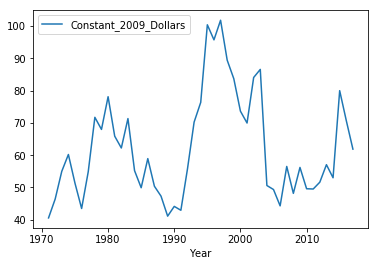

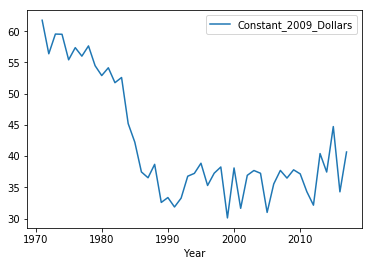

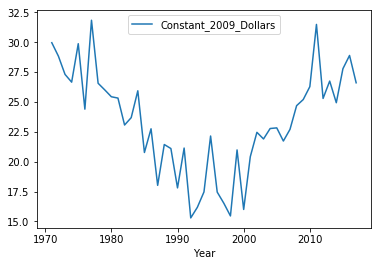

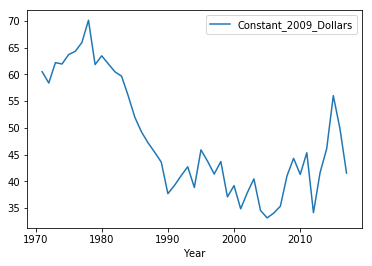

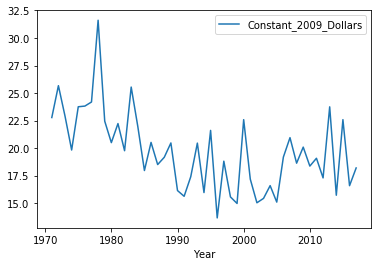

In [135]:
fresh_df = fresh_df.replace('            --', 0)
fresh_df = fresh_df.replace('             --', 0)
fresh_df.iloc[0:47].plot(y='Constant_2009_Dollars', x= 'Year')
# fresh_df.iloc[47:94].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[94:141].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[141:188].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[188:235].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[235:282].plot(y='Constant_2009_Dollars', x= 'Year')
# fresh_df.iloc[282:302].plot(y='Constant_2009_Dollars', x= 'Year')

# tomatoes, kale 
# tomatoes - prices down, produc down imports up

plt.show()

#### 4. 4 Analyze the Market price, production and imports of Tomatoes

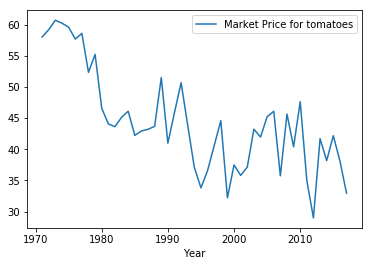

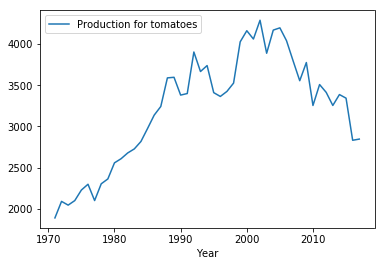

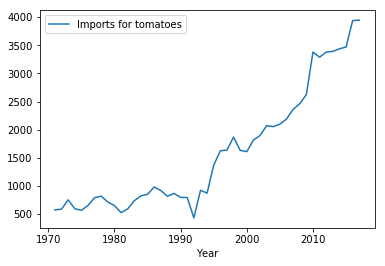

In [20]:

fresh_df.iloc[918:965].plot(y='Constant_2009_Dollars', x= 'Year', label = 'Market Price for tomatoes')
fresh_df.iloc[918:965].plot(y='Production', x= 'Year', label = 'Production for tomatoes')
fresh_df.iloc[918:965].plot(y='Imports', x= 'Year', label = 'Imports for tomatoes')
plt.legend()
plt.show()

Interesting analysis for market prices for vegetables compared to the 1970s level
Tomatoes’ prices going down
Why?
Increasing imports
Impacting production – production also reducing


#### 4.6 Plot the Market prices of vegetables for year

#### 4.6.1 Market price for vegetables

In [168]:
pi_by_year = df1.groupby('Year', as_index=False)['Price_Index'].mean() 
pi_by_year['Year'] = pi_by_year['Year'].astype(int) # convert year to int type
# merge fresh_df and pi_by_year on Year column values
final_df2 = pd.merge(fresh_df, pi_by_year, on="Year")

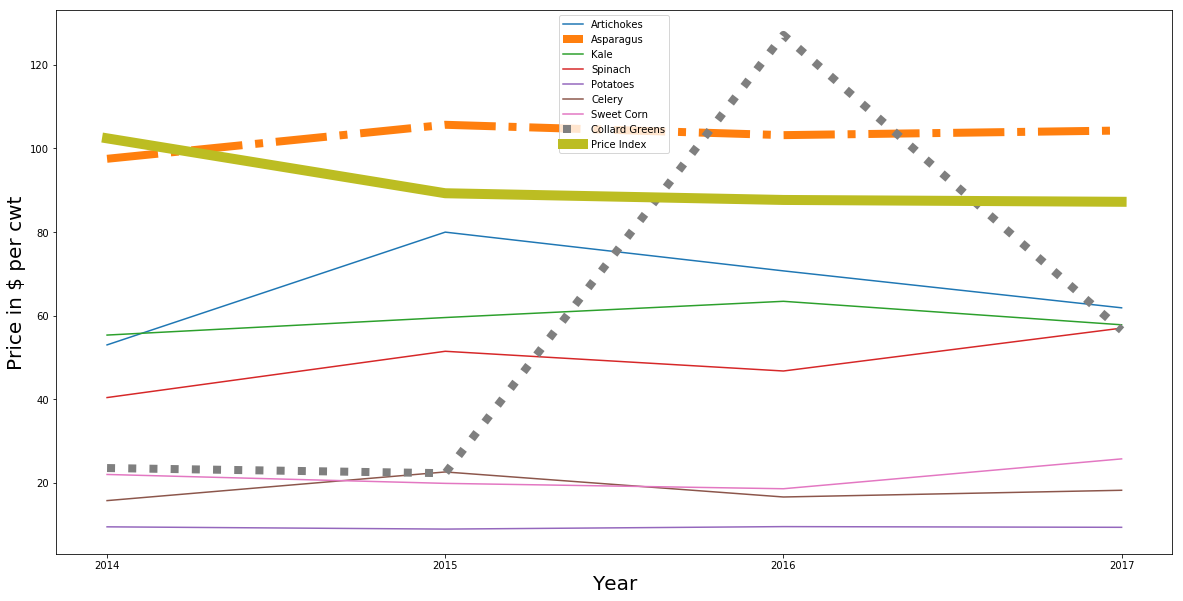

In [170]:
# final_df[:10]
final_df = final_df.replace('            --', 0)
final_df = final_df.replace('             --', 0)
final_df = final_df.replace('--', 0)
# final_df = final_df.fillna(0)
# final_df.iloc[:,1:-1].astype(float)

pmi_data = final_df2.loc[final_df2['Vegetable'].isin(['artichokes'])]
pmi_data2 = final_df2.loc[final_df2['Vegetable'].isin(['asparagus'])]
pmi_data3 = final_df2.loc[final_df2['Vegetable'].isin(['kale'])]
# pmi_data4 = final_df.loc[final_df['Vegetable'].isin(['mustard greens'])]
pmi_data5 = final_df2.loc[final_df2['Vegetable'].isin(['spinach'])]
pmi_data6 = final_df2.loc[final_df2['Vegetable'].isin(['potatoes'])] 
pmi_data7 = final_df2.loc[final_df2['Vegetable'].isin(['celery'])]
pmi_data8 = final_df2.loc[final_df2['Vegetable'].isin(['sweet corn'])]
pmi_data9 = final_df2.loc[final_df2['Vegetable'].isin(['collard greens'])]
pmi_data10 = final_df2.loc[final_df2['Vegetable'].isin(['leaf & romanie lettuce'])]
# df.loc[df['B'].isin(['one','three'])]
plt.figure(figsize=(20,10))
plt.plot(pmi_data['Year'], pmi_data['Constant_2009_Dollars'], label = 'Artichokes')
plt.plot(pmi_data2['Year'], pmi_data2['Constant_2009_Dollars'], label = 'Asparagus', linewidth=8, linestyle="-.")
plt.plot(pmi_data3['Year'], pmi_data3['Constant_2009_Dollars'], label = 'Kale')
# plt.plot(pmi_data4['Year'], pmi_data4['Constant_2009_Dollars'], label = 'Mustard Greens')
plt.plot(pmi_data5['Year'], pmi_data5['Constant_2009_Dollars'], label = 'Spinach')
plt.plot(pmi_data6['Year'], pmi_data6['Constant_2009_Dollars'], label = 'Potatoes')
plt.plot(pmi_data7['Year'], pmi_data7['Constant_2009_Dollars'], label = 'Celery')
plt.plot(pmi_data8['Year'], pmi_data8['Constant_2009_Dollars'], label = 'Sweet Corn')
plt.plot(pmi_data9['Year'], pmi_data9['Constant_2009_Dollars'], label = 'Collard Greens', linewidth=8, linestyle=":")
# plt.plot(pmi_data10['Year'], pmi_data10['Constant_2009_Dollars'], label = 'Lettuce')
plt.plot(pmi_data2['Year'], pmi_data2['Price_Index'],label = 'Price Index', linewidth=10)
plt.legend()
plt.xticks(range(2014,2018))
plt.xlabel('Year', size = 20)
plt.ylabel('Price in $ per cwt', size = 20)
plt.legend()
plt.show()

#### 4.6.2 Deep dive from above plot -Analysis of Asparagus - Why is it consistently costlier
Plot Production to import ratio to see how it varies over years

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


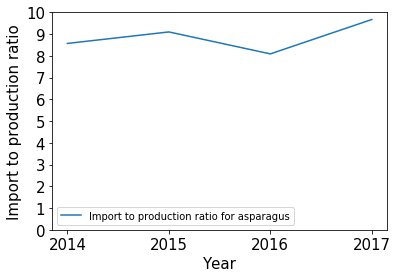

In [171]:
# Plot to show the import to Production ratio of Asparagus
asp_data = pi_analysis_df[pi_analysis_df['Vegetable'] == 'asparagus']
asp_data['Im_Prod_Ratio'] = asp_data['Imports'] / asp_data['Production']
asp_data.plot(y = 'Im_Prod_Ratio', x= 'Year', label = "Import to production ratio for asparagus")
plt.xticks(range(2014,2018), size = 15)
plt.yticks(range(11), size = 15)
plt.ylabel("Import to production ratio", size = 15)
plt.xlabel("Year", size = 15)
# plt.ylabel("Import to production ratio")
plt.show()